In [1]:
# Google Colab에서 노트북을 실행하실 때에는
# https://tutorials.pytorch.kr/beginner/colab 를 참고하세요.
# https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html
%pip install torch torchvision torchmetrics numpy tqdm matplotlib inline -qq
# %matplotlib 

Note: you may need to restart the kernel to use updated packages.


### 1. CIFAR10을 불러오고 정규화하기


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


데이터셋 샘플 출력



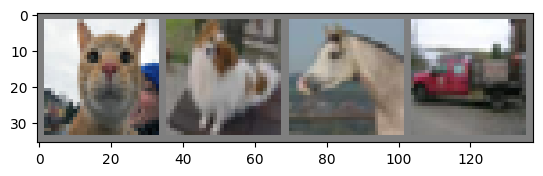

cat
dog
horse
truck


In [17]:
# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))
for label in labels[:4]:
  print(classes[label])

### 2. 합성곱 신경망(Convolution Neural Network) 정의하기


In [5]:
import torch.nn as nn
import torch.nn.functional as F


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
  return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                   padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
  return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class Block(nn.Module):

  def __init__(self, in_planes, out_planes, stride=1, relu=nn.ReLU, log=False):
    super(Block, self).__init__()
    self.isLog  = log
    self.relu   = relu(inplace=True)
    self.conv1  = conv3x3(in_planes, out_planes, stride=stride)
    self.bn1    = nn.BatchNorm2d(out_planes)
    self.conv2  = conv3x3(out_planes, out_planes, stride=1)
    self.bn2    = nn.BatchNorm2d(out_planes)
    self.down   = None
    if (stride != 1) or (in_planes != out_planes):
      self.down = nn.Sequential(
        conv1x1(in_planes, out_planes, stride=stride),
        nn.BatchNorm2d(out_planes),
      )

  def forward(self, x):
    residual = x;      self.log("b.start", x.shape)

    x = self.conv1(x); self.log("b.conv1", x.shape)
    x = self.bn1(x)
    x = self.relu(x)

    x = self.conv2(x); self.log("b.conv2", x.shape)
    x = self.bn2(x)

    if self.down is not None:
      residual = self.down(residual)
      self.log("b.res  ", residual.shape)

    x += residual
    x = self.relu(x);  self.log("b.end  ", x.shape)

    return x

  def log(self, tag, x=None):
    if not self.isLog:
      return
    if x is None:
      print(tag)
    else:
      print(tag, x)

  # def in_planes(self):
  #   return self.in_planes

  # def out_planes(self):
  #   return self.out_planes


class ResNet(nn.Module):

  def __init__(self, block=Block, layers=[2, 2, 2], num_classes=10, log=False):
    super(ResNet, self).__init__()
    self.isLog        = log
    self.norm_layer = nn.BatchNorm2d
    self.relu       = nn.ReLU(inplace=True)
    self.num_classes = num_classes

    P = 16
    Q = 2

    # Stack layer
    self.conv1   = conv3x3(3, P)
    self.bn1     = self.norm_layer(P)
    # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.layer1  = self._make_layer(block, P, P * 2, layers[0], stride=2); P *= 2
    self.layer2  = self._make_layer(block, P, P * 2, layers[1], stride=2); P *= 2
    self.layer3  = self._make_layer(block, P, P * 2, layers[2], stride=2); P *= 2
    self.avg     = nn.AdaptiveAvgPool2d(Q)
    self.flat    = nn.Flatten()
    self.fc      = nn.Linear(P * Q * Q, num_classes)

    # Initialize weight
    self._init_weight()
  
  def _init_weight(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

  def _make_layer(self, block, in_planes, out_planes, blocks, stride):
    layers = []
    layers.append(block(in_planes, out_planes, stride, log=self.isLog))
    for _ in range(blocks - 1):
      layers.append(block(out_planes, out_planes, log=self.isLog))

    return nn.Sequential(*layers)

  def forward(self, x):
    self.log("start", x.shape)

    x = self.conv1(x);   self.log("conv1", x.shape)
    x = self.bn1(x)
    x = self.relu(x)
    # x = self.maxpool(x)

    self.log("layer1")
    x = self.layer1(x)

    self.log("layer2")
    x = self.layer2(x)

    self.log("layer3")
    x = self.layer3(x)

    x = self.avg(x);  self.log("pool", x.shape)
    x = self.flat(x); self.log("flat", x.shape)
    x = self.fc(x);   self.log("fc", x.shape)

    self.log("end", x.shape)
    return x

  def log(self, tag, x=None):
    if not self.isLog:
      return
    if x is None:
      print(tag)
    else:
      print(tag, x)


net = ResNet()

테스트 및 차원 확인

In [18]:
# Print dimension
lognet = ResNet(log=True)
trainiter = iter(trainloader)
inputs, labels = next(trainiter)
outputs = lognet(inputs)
outputs[0].shape

start torch.Size([256, 3, 32, 32])
conv1 torch.Size([256, 16, 32, 32])
layer1
b.start torch.Size([256, 16, 32, 32])
b.conv1 torch.Size([256, 32, 16, 16])
b.conv2 torch.Size([256, 32, 16, 16])
b.res   torch.Size([256, 32, 16, 16])
b.end   torch.Size([256, 32, 16, 16])
b.start torch.Size([256, 32, 16, 16])
b.conv1 torch.Size([256, 32, 16, 16])
b.conv2 torch.Size([256, 32, 16, 16])
b.end   torch.Size([256, 32, 16, 16])
layer2
b.start torch.Size([256, 32, 16, 16])
b.conv1 torch.Size([256, 64, 8, 8])
b.conv2 torch.Size([256, 64, 8, 8])
b.res   torch.Size([256, 64, 8, 8])
b.end   torch.Size([256, 64, 8, 8])
b.start torch.Size([256, 64, 8, 8])
b.conv1 torch.Size([256, 64, 8, 8])
b.conv2 torch.Size([256, 64, 8, 8])
b.end   torch.Size([256, 64, 8, 8])
layer3
b.start torch.Size([256, 64, 8, 8])
b.conv1 torch.Size([256, 128, 4, 4])
b.conv2 torch.Size([256, 128, 4, 4])
b.res   torch.Size([256, 128, 4, 4])
b.end   torch.Size([256, 128, 4, 4])
b.start torch.Size([256, 128, 4, 4])
b.conv1 torch.Size(

torch.Size([10])

### 3. 손실 함수와 Optimizer 정의하기



In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=0.001)
optimizer = optim.AdamW(net.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.01, eps=1e-8)

### 4. 신경망 학습하기


In [8]:
def train(total_epoch=30, update_freq=1, stop_loss=0.0):
  total_progress = len(trainloader) * total_epoch
  pbar = tqdm(range(total_progress), position=0, miniters=update_freq)

  # Train
  for epoch in range(total_epoch):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
      inputs, labels = data

      # 변화도(Gradient) 매개변수를 0으로 만들고
      optimizer.zero_grad()

      # 순전파 + 역전파 + 최적화를 한 후
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # 통계를 출력합니다.
      running_loss += loss.item()
      if i % update_freq == update_freq - 1:    # print every k mini-batches
        pbar.update(update_freq)
        avg_loss = running_loss / update_freq
        pbar.set_description(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}')
        if avg_loss < stop_loss:
          pbar.close()
          return
        running_loss = 0.0

  pbar.close()

train(total_epoch=30)
print('Finished Training')

[30,   196] loss: 0.032: 100%|██████████| 5880/5880 [2:41:45<00:00,  1.65s/it]     

Finished Training


학습한 모델 저장



In [10]:
# PATH = './cf1_v1_e30.pth'
# torch.save(net.state_dict(), PATH)

### 5. 시험용 데이터로 신경망 검사하기



In [29]:
PATH = './cf1_v1_e30.pth'
net = ResNet()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [12]:
# Gather results
preds = torch.empty(0)
actual = torch.empty(0)

with torch.no_grad():

  pbar = tqdm(total=len(testloader), position=0, leave=True)

  for data in testloader:

    images, labels = data
    outputs = net(images)
    preds = torch.cat((preds, torch.softmax(outputs, 1)), dim=0)
    actual = torch.cat((actual, labels), dim=0)

    pbar.update(1)

  pbar.close(); print()

# print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

100%|██████████| 40/40 [00:31<00:00,  1.27it/s]

Raw output

In [26]:
preds[0], actual[0]

(tensor([0.1361, 0.0622, 0.0553, 0.1065, 0.1289, 0.0711, 0.0772, 0.1571, 0.1081,
         0.0976]),
 tensor(3.))

In [14]:
import torchmetrics
# Define metrics
precision = torchmetrics.Precision(task="multiclass", average='macro', num_classes=10)
recall = torchmetrics.Recall(task="multiclass", average='macro', num_classes=10)
accuracy = torchmetrics.Accuracy(task="multiclass", average='macro', num_classes=10)
accuracy10 = torchmetrics.Accuracy(task="multiclass", average=None, num_classes=10)

# Update metric states
precision.update(preds, actual)
recall.update(preds, actual)
accuracy.update(preds, actual)
accuracy10.update(preds, actual)

# Compute the metrics
precision_val = precision.compute()
recall_val = recall.compute()
accuracy_val = accuracy.compute()
accuracy10_val = accuracy10.compute()

print("precision", precision_val)
print("recall   ", recall_val)
print("accuracy ", accuracy_val)
print("accuracy ", accuracy10_val)

precision tensor(0.7411)
recall    tensor(0.7419)
accuracy  tensor(0.7419)
accuracy  tensor([0.8070, 0.8630, 0.5930, 0.5410, 0.7210, 0.6630, 0.7980, 0.7510, 0.8630,
        0.8190])
